In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'Accuracy: {round(accuracy, 2)}')
    recall = (tp) / (tp + fn)
    print(f'Recall: {round(recall, 2)}')
    precision = (tp) / (tp + fp)
    print(f'Precision: {round(precision, 2)}')
    print(f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}')
    return (accuracy, recall, precision)

In [14]:
#prints number of features, stop words and parameters for vectorizer
def vectorizer_parameters(vectorizer):
    #features
    feat_names = vectorizer.get_feature_names()
    num_feat = len(feat_names)
    
    #stop words
    stop_words = vectorizer.stop_words_
    num_stop = len(stop_words)

    params = vectorizer.get_params()
    
    print(f'Number of features: {num_feat}, Numbers of stop words: {num_stop}')
      
    for key, val in params.items():
        print(f'{key}: {val}')

In [15]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [16]:
#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','lead_paragraph','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [17]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [18]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)
    df = df[df[keyword] == True]
    return df

In [19]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    #plt.savefig('img/oped_news_hist.png')

In [20]:
#split article and return quote
def return_quote(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
        
    return(quotation)

In [21]:
#split article and return quote
def return_article(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
    
    return(article)

In [22]:
data = pd.read_csv('token_2010_2020.csv', index_col='_id')

In [23]:
%%time
df = data.copy()

CPU times: user 2.12 ms, sys: 405 µs, total: 2.52 ms
Wall time: 2.54 ms


In [24]:
df.shape

(27461, 9)

In [25]:
df = filter_keyword(df)

In [26]:
df.head()

,lead_paragraph,keywords,pub_date,type_of_material,print_page,text,United States Politics and Government,quote_list,keyword_list
_id,,,,,,,,,
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e,"On the first Monday in May, the Department of ...","[{'name': 'persons', 'value': 'Barr, William P...",2020-06-01T09:00:11+0000,News,20.0,as you drew closer to the fifth floor where ...,True,[[]],"['', 'Barr,', 'William', 'P', 'Justice', 'Depa..."
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3,"Under normal circumstances, Joseph R. Biden Jr...","[{'name': 'subject', 'value': 'Presidential El...",2020-06-01T09:01:09+0000,News,14.0,at a moment that is emerging as a critical te...,True,[[]],"['', 'Presidential', 'Election', 'of', '2020',..."
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf,The Supreme Court on Monday unanimously upheld...,"[{'name': 'organizations', 'value': 'Supreme C...",2020-06-01T16:38:59+0000,News,15.0,court ruled that members of a government boar...,True,[[]],"['', 'Supreme', 'Court', '(US)', 'Puerto', 'Ri..."
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568,"An international team of scientists, including...","[{'name': 'subject', 'value': 'Coronavirus (20...",2020-06-01T16:42:18+0000,News,6.0,their report posted online they also point t...,True,[[]],"['', 'Coronavirus', '(2019-nCoV)', 'Bats', 'SA..."
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c,WASHINGTON — President Trump on Monday angrily...,"[{'name': 'subject', 'value': 'George Floyd Pr...",2020-06-01T17:20:54+0000,News,1.0,said in brief remarks in the the presiden...,True,[[]],"['', 'George', 'Floyd', 'Protests', '(2020)', ..."


In [27]:
df.text.iloc[0]

' as you drew closer to the fifth floor where      works out of a suite of offices things started to loosen up  assistant outside his conference room wore a mask but the other did not  the middle of the room with its oil paintings and vaulted ceiling the long central table had fewer chairs than you might expect and an appropriate distance between them  past the next door inside the attorney generals smaller personal office  himself was also mask-free  around to greet his visitors he moved into the middle of a wide circle of four chairs arranged in front of his desk  nearing the end of his career  did not take his current job for the glory  had already been attorney general once in      administration winning him a reputation as a wise old man a reputation that in the eyes of some his tenure in the  administration has tarnished  is he doing it for the money  time in corporate  earned him tens of millions of dollars in compensation and stock options and his bearing is still that of a  50

In [28]:
last_check_before_split = (df.iloc[0])
last_check_before_split

lead_paragraph                           On the first Monday in May, the Department of ...
keywords                                 [{'name': 'persons', 'value': 'Barr, William P...
pub_date                                                          2020-06-01T09:00:11+0000
type_of_material                                                                      News
print_page                                                                            20.0
text                                      as you drew closer to the fifth floor where  ...
United States Politics and Government                                                 True
quote_list                                                                            [[]]
keyword_list                             ['', 'Barr,', 'William', 'P', 'Justice', 'Depa...
Name: nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e, dtype: object

News: 22160 Oped: 5301, Total: 27461, Op-Ed 0.19 of total


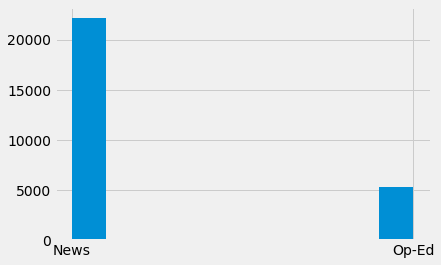

In [29]:
oped_v_news(df)

# drop na

In [30]:
df.shape

(27461, 9)

In [31]:
df = df.dropna()

In [32]:
df.shape

(27406, 9)

# X, y

In [33]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [34]:
#turn series into list...
corpus = list(X)

In [35]:
corpus[0]

' as you drew closer to the fifth floor where      works out of a suite of offices things started to loosen up  assistant outside his conference room wore a mask but the other did not  the middle of the room with its oil paintings and vaulted ceiling the long central table had fewer chairs than you might expect and an appropriate distance between them  past the next door inside the attorney generals smaller personal office  himself was also mask-free  around to greet his visitors he moved into the middle of a wide circle of four chairs arranged in front of his desk  nearing the end of his career  did not take his current job for the glory  had already been attorney general once in      administration winning him a reputation as a wise old man a reputation that in the eyes of some his tenure in the  administration has tarnished  is he doing it for the money  time in corporate  earned him tens of millions of dollars in compensation and stock options and his bearing is still that of a  50

In [36]:
# define y as a series of op-ed or news
y = df.type_of_material

In [37]:
vectorize_y_ser(y)

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/8ebe71ee-2cbe-5c25-8d4a-91696cff67d4    0
nyt://article/87f0a2b8-39f6-5fb5-a076-a4949353400e    0
nyt://article/a6e31872-431b-5b24-8d35-dfae18af1f0c    0
nyt://article/bd4bc1cd-7cbc-525e-a65c-76c6b338e331    0
nyt://article/a56ad218-e173-568e-b4b5-ddd584ec79cb    0
Name: type_of_material, Length: 27406, dtype: int64

In [38]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 11.5 ms, sys: 1.16 ms, total: 12.7 ms
Wall time: 12.2 ms


In [39]:
y.value_counts()

0    22122
1     5284
Name: type_of_material, dtype: int64

In [40]:
y.shape
X.shape

(27406,)

# remove stop words

# stemming/lemmatization

In [41]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [42]:
# %%time
# def snowball_tokenize(doc):
#     snowball = SnowballStemmer('english')
#     return [snowball.stem(word) for word in word_tokenize(doc.lower())]

In [43]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


# vectorizer

# WORDNET tfidf

In [44]:
import string

In [45]:
print(string.punctuation)
print('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [46]:
# nytimes_quotes = "”“"
# nytimes_punctuation = "—’"

In [47]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~':
            document = document.replace(char, " ")
    return document

In [213]:
final_stop = ['', 'over', 'john', 'email', 'discus', 'in', 'word', 'inquiry', 'acknowledged',
              'despite', 'three', 'amid', 'television', 'business', 'aren', 'never', 'thursday',
              'told', 'chairman', 'plan', 'given', 'medium', 'prompted', 'spirit', 'voter', 
              'before', 'face', '2019', 'm', 'think', 'director', 'citizen', 'panel', 
              'spokesman', 'become', 'expert', 'idea', 'matter', 'previously', 'family', 'rule',
              'rich', 'during', 'few', '40', 'criticized', 'social', 'unclear', 'final', 'v', 
              'role', 'selection', 'same', 'while', 'report', 'u', 'announcement', 'record', 
              '” “', 'let', 'democratic', 'way', 'disclosed', 've', 'doe', 'c', 'and', 'out', 
              'joe', 'noted', 'major', 'if', 'intended', 'understanding', 'data', 'dispute', 
              'white', 'take', 'operation', 'i', 'place', 'request', 'go', 'congress', 'worse',
              'mean', 'investigation', 'x', 'catastrophe', 'then', 'small', 'were', 'those',
              'decision', 'covid', 'looking', 'not', 'lost', 'doesn', 'received', 'response',
              'evidence', 'might', 'tested', 'another', 'b', 'representative', 'h', 'something',
              'are', 'up', 'where', 'released', 'joined', 'delay', 'institution', '10', 'yet',
              'back', 'democracy', 'want', 'added', 'order', 'discussion', 'four', 
              'california', 'early', 'man', 'against', 'sought', 'wrote', 'first', 'began', 
              'for', 'company', 'chief', 'university', 'only', 'described', 'concern', 'our', 
              'terrible', 'ago', 'based', 'him', 'memo', 'keep', 'accused', 'put', 'much', 
              'new', 'joseph', 'detail', 'second', 'briefed', 'economy', 'lawmaker', 'right', 
              'candidate', 'reporter', 'aide', 'better', 'earlier', 'y', 'statement', 'mr', 
              'obama', 'death', 'century', 'willing', 'defended', 'administration', 'why', 
              'call', 'just', 'comment', 'off', 'public', 'often', 'clear', 'won', 'nature',
              'crisis', 'view', 'himself', 'member', 'pandemic', 'n', 'around', 'allowing', 
              'office', 'survive', 'employee', 'you', 'according', 'government', 'york', 'know',
              'until', 're', 'say', 'reason', 'coronavirus', 'executive', 'wednesday', 'seems',
              'with', 'house', 'economic', 'conservative', 'got', 'decent', 'deputy', 'review',
              '13', 'me', 'expressed', 'joint', 'could', 'two', 'appeared', 'k', 'thing', 
              'legal', 'moment', 'an', 'made', 'risk', 'longtime', 'which', 'george', 'part', 
              'city', 'team', 'committee', 'opportunity', 'working', 'largely', 'including', 
              'top', 'guy', '500', 'somehow', 'others', 'everyone', 'like', 'o', 'both', 
              'wrong', 'time', 'group', 'by', 'person', 'between', 'have', 'term', 'professor',
              'washington', 'most', 'freedom', 'america', 'whole', 'job', 'society', 'twitter',
              'her', 'law', 'secretary', 'gathered', 'many', 'w', 'give', 'appearance', 'from',
              'cited', 'seek', 'lawsuit', 'next', 'program', 'showed', 'disclose', 'committed',
              'afternoon', 'late', 'actually', 'interview', 'party', 'either', 'least', 
              'through', 'several', 'court', 'imagine', 'whether', 'down', 'event', 'long', 
              'department', 'happens', 'week', 'electoral', 'strategist', 'politician', 
              'objection', 'taken', '2001', 'vote', 'probably', 'seem', 'chairwoman', 'policy',
              'trying', 'leader', 'radical', 'agreement', 'living', 'must', 'supposed', 'local',
              'result', 'should', 'highlighted', 'familiar', 'south', 'set', '30', 'recent', 
              'health', 'expected', 'look', 'democrat', 'friday', 'tuesday', 'adding', '2018', 
              'post', '2', 'effort', 'officer', 'nothing', 'series', 'she', 'treasury', 'world',
              'course', 'later', 'posted', 'they', 'other', 'fund', 'my', 'find', 'senator', 
              'bill', 'but', 'referring', 'across', 'biden', 'don', 'q', 'effective', 'f', 
              'dead', 'sense', 'extensive', 'challenging', 'do', 'is', 'funding', 'getting', 
              'organization', 'be', 'publicly', 'your', 'directed', 'isn', 'shared', 'sort', 
              'fact', 'point', 'five', 'led', '2016', 'aggressive', 'about', 'meeting', 'there',
              'college', 'general', 'lot', 'come', 'now', 'agency', 'found', 'such', 'vice', 
              'campaign', 'used', 'called', 'billion', 'bit', 'no', 'more', 'am', 'after', 
              'raised', 'year', 'thinking', 'when', 'indicated', 'decency', 'all', 'weren', 
              'senior', 'them', 'justice', 'pretty', 'former', 'act', 'privately', 'we', 
              'self', 'may', 'every', 'making', 'support', 'kill', 'federal', 'disclosure', 
              'been', 'a', 'because', 'since', 'said', 'bigger', 'would', 'included', 
              'presidential', 'wa', 'move', 'run', 'completely', 'ordinary', 'million', 
              'critical', 'donald', 'different', 'else', 'end', 'll', 'attack', 'e', 
              'information', 'war', 'selected', 'l', 't', 'offered', 'large', 'any', 
              'didn', 'very', 'done', 'president', 'ha', 'served', 'analyst', 
              'among', 'again', 'private', 'night', 'ever', 'how', 'remark', 
              'line', 'nation', 'political', 'country', 'each', 'so', 'warned', 'united', 
              'worker', 'official', 'intelligence', 'these', 'barack', 'away', 'lobbyist', 
              '1', 'racism', 'came', 'being', 'good', 'religious', 'criticism', 'worked', 
              'past', 'chaos', 'battleground', 'one', 'sent', 'presidency', 'include', 'case', 
              'work', 'son', 'too', 'the', 'hard', 'asked', 'going', 'adviser', 'home', 
              'perfectly', 'than', 'money', 'hour', 'doing', 'that', 'supporter', 'took', 
              'real', 'county', 'position', 'get', 'signed', 'once', 'win', 'at', 'care', 
              'system', 'future', 'today', 'close', 'declined', 'though', 'far', 'problem', 
              'story', 'or', 'enough', 'remember', 'his', 'itself', 'anyone', 'turn', 'black', 
              'claim', 'trump', 'decade', 'school', 'returning', 'spokeswoman', 'election', 
              'national', 'monday', 'did', 'message', 'high', 'age', 'issued', 'planned', 
              'month', 'everything', 'tie', 'common', 'always', 'percent', 'into', 'spoken', 
              'related', 'on', 'to', 'really', 'complained', 'last', 'true', 'already', 'fair',
              'congressional', 'it', 'american', 'center', 'can', 'he', 'number', 'ourselves', 
              'staff', 'virus', 'p', 'change', 'day', 'make', '000', 'lawyer', 'news', 'hosted',
              's', 'dozen', 'happen', 'also', 'will', 'had', 'little', 'z', 'jr', 'lead', 'left',
              'senate', 'minnesota', 'this', 'bad', 'action', 'yes', '3', 'see', 'online', 'd', 
              'letter', 'ally', 'life', 'who', 'tell', 'r', 'mind', 'region', 'rest', 'feel', 
              'behavior', 'power', 'wouldn', 'document', 'best', 'politics', 'march', 'largest',
              'security', 'some', 'here', 'respect', 'under', 'announced', 'own', 'elected', 
              'understand', 'forget', 'easy', 'without', 'saying', 'of', 'whose', 'le', 'even', 
              'service', 'child', 'republican', 'questioned', 'well', 'need', 'j', 'held', 
              'state', 'assessment', 'show', 'issue', 'their', 'what', 'use', 'wasn', 'still', 
              'people', 'however', 'g', 'majority', 'hoped', 'involving', 'hadn', 'restriction',
              'fix', '', 'industry', '', '', 'lobbying', '', 'ego', 'dark', 'obtained', '', 
              'none', 'blocked', 'remained', 'economist', 'wisdom', 'evening', 'die', 'direction'
              , 'hear', 'ending', 'citing', '…', 'hate', 'character', 'trial', 'six', 'couldn', 
              'conference', 'reality', 'populist', '7', '', '', 'spent', 'simply', 'airing', 
              'bid', 'huge', 'manufacturer', 'slavery', '', '', '', 'mass', 'deserves', '', '', 
              '', 'maintained', 'education', 'innovative', 'visit', 'simple', 'trip', 'equally',
              'handling', 'difficult', 'session', 'maybe', 'quite', 'thus', 'overseas', 'ad', 
              'viewed', 'choose', 'regard', '', 'stand', 'expect', 'half', '', 'conversation', 
              'dream', 'accusation', 'drew', 'happening', 'accountability', 'seeking', 'ignore',
              'regularly', 'manager', '', '', '', '', 'sound', 'anonymity', 'additional', 
              'infrastructure', '6', '“', '”', 'kid', '', 'website', 'dictator', 'themselves', 
              'smart', 'someone', '', '', 'raising', 'discussed', 'resolution', '', '', 'allow',
              'income', 'live', 'equality', 'everybody', 'scrutiny', 'contact', 'investigating',
              'measure', 'target', 'honest', 'turning', 'thanks', 'lengthy', 'contract', 
              'mistake', 'briefing', 'separate', 'annual', 'traveled', 'hope', '5', '', 
              'proposed', 'continued', 'treat', '', 'cultural', '', '', '', 'example', '', 
              'mess', 'deal', 'brings', 'assistant', 'eager', 'reform', 'wouldnt', '', 
              'advocacy', '', '', 'provision', 'youd', 'overhaul', '', '', 'counsel', '', 
              'indeed', '', 'class', '', 'guess', '', '', 'negotiation', '', 'value', 'theyve',
              'didnt', '', 'arent', 'thats', 'column', 'deserve', 'culture', 'filed', 
              'important', '', 'happened', 'urged', 'anything', 'hasnt', 'whats', '', '', '', '',
              'preparing', 'sure', 'cant', 'isnt', 'youre', 'kid', 'potentially', 'website', 
              'dictator', 'themselves', 'smart', 'someone', 'propaganda', 'pundit', 'raising', 
              'discussed', 'resolution', '', '', '', 'income', 'live', '', 'everybody', 
              'scrutiny', 'contact', 'investigating', 'measure', 'target', '', 'turning', 
              'thanks', 'lengthy', 'contract', 'mistake', 'briefing', 'separate', 'annual', 
              'traveled', 'hope', '5', '', 'proposed', 'continued', 'treat', '', 'cultural', 
              'exists', '', '', 'example', '', 'mess', 'deal', 'brings', 'assistant', 'eager',
              'reform', 'wouldnt', 'corrupt', 'advocacy', '', 'fantasy', 'provision', 'youd', 
              'overhaul', '', 'hatred', 'counsel', '', 'indeed', 'whatsoever', 'class', '', 
              'guess', '', 'obviously', 'negotiation', '', 'value', 'theyve', 'didnt', 'arent', 
              'thats', 'column', 'deserve', 'culture', 'filed', 'important', 'exactly', 
              'happened', 'urged', 'anything', 'hasnt', 'whats', '', 'preparing', 
              'sure', 'cant', 'isnt', 'youre','extreme', 'liberalism', 'met', 'absolutely', 'known', 'schedule',
       'learned', 'enemy', 'humanity', 'rather', 'addition', 'hearing',
       'lesson', 'surely', 'definitely', 'shouldnt', 'greatest', 'skill',
       'old', 'afraid', 'weve', '', 'worst', 'morning', 'firm', 'lie',
       'obvious', '', 'interesting', 'release', 'cruelty', 'ranking',
       'racist', 'learn', 'noting', 'illegally', 'folk', 'opposite',
       'formally', '', 'scheduled', 'hed', 'wont', 'requested', '',
       'theyre', 'havent', 'nobody', 'werent', '']

In [214]:
len(final_stop)

1018

In [215]:
stop_words = set(final_stop)

In [216]:
len(stop_words)

880

In [217]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
#                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=final_stop,
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 2), 
                 max_df=0.7, 
#                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 1.36 ms, sys: 504 µs, total: 1.86 ms
Wall time: 1.87 ms


# test, train, split

In [218]:
#test, train, split

In [219]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

(20554,) (6852,) (20554,) (6852,)
CPU times: user 2min 20s, sys: 314 ms, total: 2min 20s
Wall time: 2min 20s


In [220]:
X_train.shape

(20554, 44427)

In [221]:
X_test.shape

(6852, 44427)

# count vectorizer

In [222]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [223]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 3981), (1, 3981)]
RandomUnderSampler(random_state=0)
CPU times: user 12.4 ms, sys: 3.45 ms, total: 15.9 ms
Wall time: 15 ms


# random forest classifier

In [224]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

2021-01-10 21:23:06.807037
CPU times: user 432 µs, sys: 95 µs, total: 527 µs
Wall time: 522 µs


In [225]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(6852,)

### metrics y_pred

In [226]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [227]:
print(y_test.shape)
print(y_pred.shape)

(6852,)
(6852,)


In [228]:
metrics_(tn, fp, fn, tp)

Accuracy: 0.87
Recall: 0.76
Precision: 0.63
TN:4963 FP:586 FN:307 TP:996


(0.8696730881494454, 0.7643898695318496, 0.629582806573957)

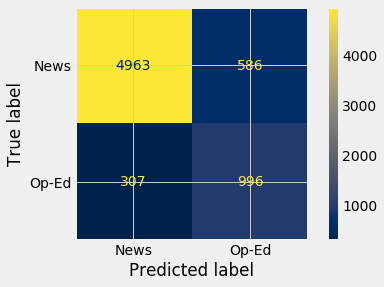

In [229]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                      cmap='cividis')
plt.savefig('img/confusion_matrix.png');

# vectorizer parameters

In [230]:
vectorizer_parameters(vectorizer)

Number of features: 44427, Numbers of stop words: 0
analyzer: word
binary: False
decode_error: strict
dtype: <class 'numpy.float64'>
encoding: utf-8
input: content
lowercase: True
max_df: 0.7
max_features: None
min_df: 1
ngram_range: (1, 1)
norm: l2
preprocessor: <function punc_strip at 0x7ffdcf8437a0>
smooth_idf: True
stop_words: ['', 'over', 'john', 'email', 'discus', 'in', 'word', 'inquiry', 'acknowledged', 'despite', 'three', 'amid', 'television', 'business', 'aren', 'never', 'thursday', 'told', 'chairman', 'plan', 'given', 'medium', 'prompted', 'spirit', 'voter', 'before', 'face', '2019', 'm', 'think', 'director', 'citizen', 'panel', 'spokesman', 'become', 'expert', 'idea', 'matter', 'previously', 'family', 'rule', 'rich', 'during', 'few', '40', 'criticized', 'social', 'unclear', 'final', 'v', 'role', 'selection', 'same', 'while', 'report', 'u', 'announcement', 'record', '” “', 'let', 'democratic', 'way', 'disclosed', 've', 'doe', 'c', 'and', 'out', 'joe', 'noted', 'major', 'if', 

# important features

### feature imporance

2021-01-10 21:23:08.338658
CPU times: user 418 ms, sys: 30.8 ms, total: 449 ms
Wall time: 446 ms


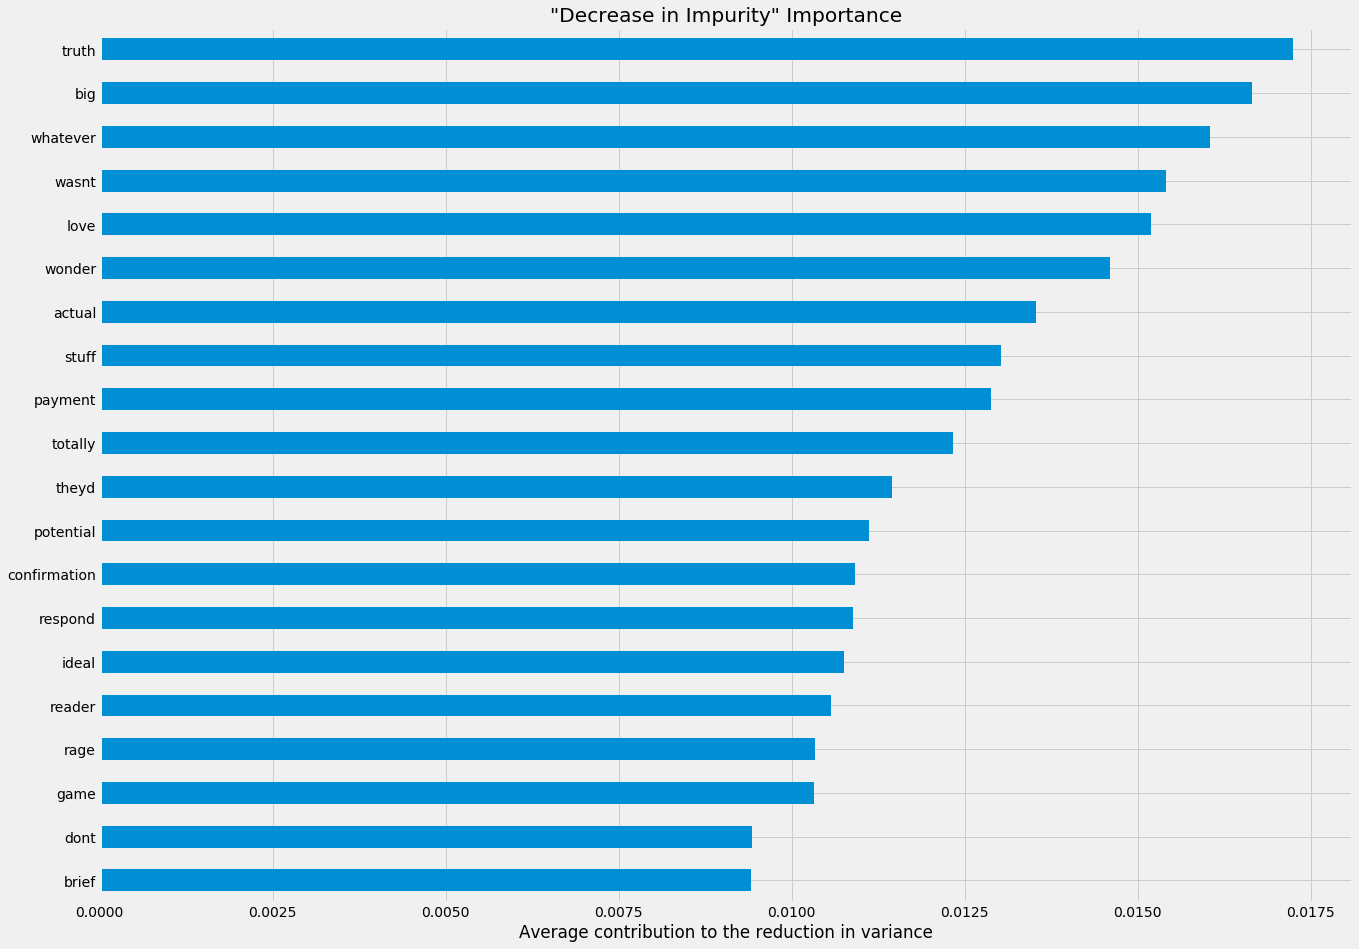

In [231]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import, index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('img/feature_imporance.png');

In [232]:
feat_scores[-100:].index

Index(['imposed', 'client', 'includes', 'particularly', 'exist', 'shes',
       'morality', 'unusual', 'clashed', 'struggled', 'proposal', 'consultant',
       'innovation', 'equal', 'prosecutor', 'agent', 'initial', 'initially',
       'becomes', '2013', 'nonsense', 'signaled', 'receive', 'formal',
       'charged', 'vowed', 'finally', 'legislation', 'conservatism', 'um',
       'critic', 'bear', 'bunch', 'aggressively', 'bigotry', 'betrayal',
       'oversees', 'communication', 'criticizing', 'sensible', 'nice',
       'appreciate', 'internal', 'nonprofit', 'file', 'push', 'throw',
       'horror', 'confirmed', 'partner', 'wealth', 'soul', 'awful',
       'suggested', 'poor', 'talking', 'strange', 'free', 'quickly',
       'yourself', 'theyll', 'wed', 'hell', 'agreed', 'deadline', 'wing',
       'certainly', 'monster', 'moral', 'judge', 'bolster', 'pressed',
       'utterly', 'lose', 'almost', '20th', 'excellent', 'cynicism', 'advised',
       'doesnt', 'brief', 'dont', 'game', 'rage

In [233]:
count_df = df[['text', 'type_of_material']]
oped = count_df[count_df['type_of_material'] == "Op-Ed"]
news = count_df[count_df['type_of_material'] == "News"]

In [266]:
print(oped.shape)
print(news.shape)

(5284, 2)
(22122, 2)


In [234]:
oped_string = oped.text.str.cat(sep = " ")

In [235]:
news_string = news.text.str.cat(sep = " ")

# counting

In [286]:
top_10 = feat_scores[-15:].index

In [292]:
oped_list = [word for word in oped_string.split() if word in list(top_10)]
oped_ed_counter = Counter(oped_list)

In [293]:
oped_ed_counter.items()

dict_items([('truth', 1063), ('wasnt', 1066), ('wonder', 419), ('love', 603), ('big', 2224), ('actual', 480), ('respond', 278), ('whatever', 471), ('stuff', 260), ('potential', 554), ('totally', 211), ('ideal', 148), ('confirmation', 231), ('theyd', 195), ('payment', 58)])

In [294]:
news_list = [word for word in news_string.split() if word  in list(top_10)]
news_counter = Counter(news_list)
news_counter.items()

dict_items([('wonder', 297), ('big', 4006), ('potential', 5069), ('confirmation', 2834), ('wasnt', 920), ('whatever', 658), ('respond', 2631), ('truth', 613), ('totally', 96), ('theyd', 88), ('actual', 647), ('payment', 987), ('ideal', 205), ('love', 543), ('stuff', 149)])

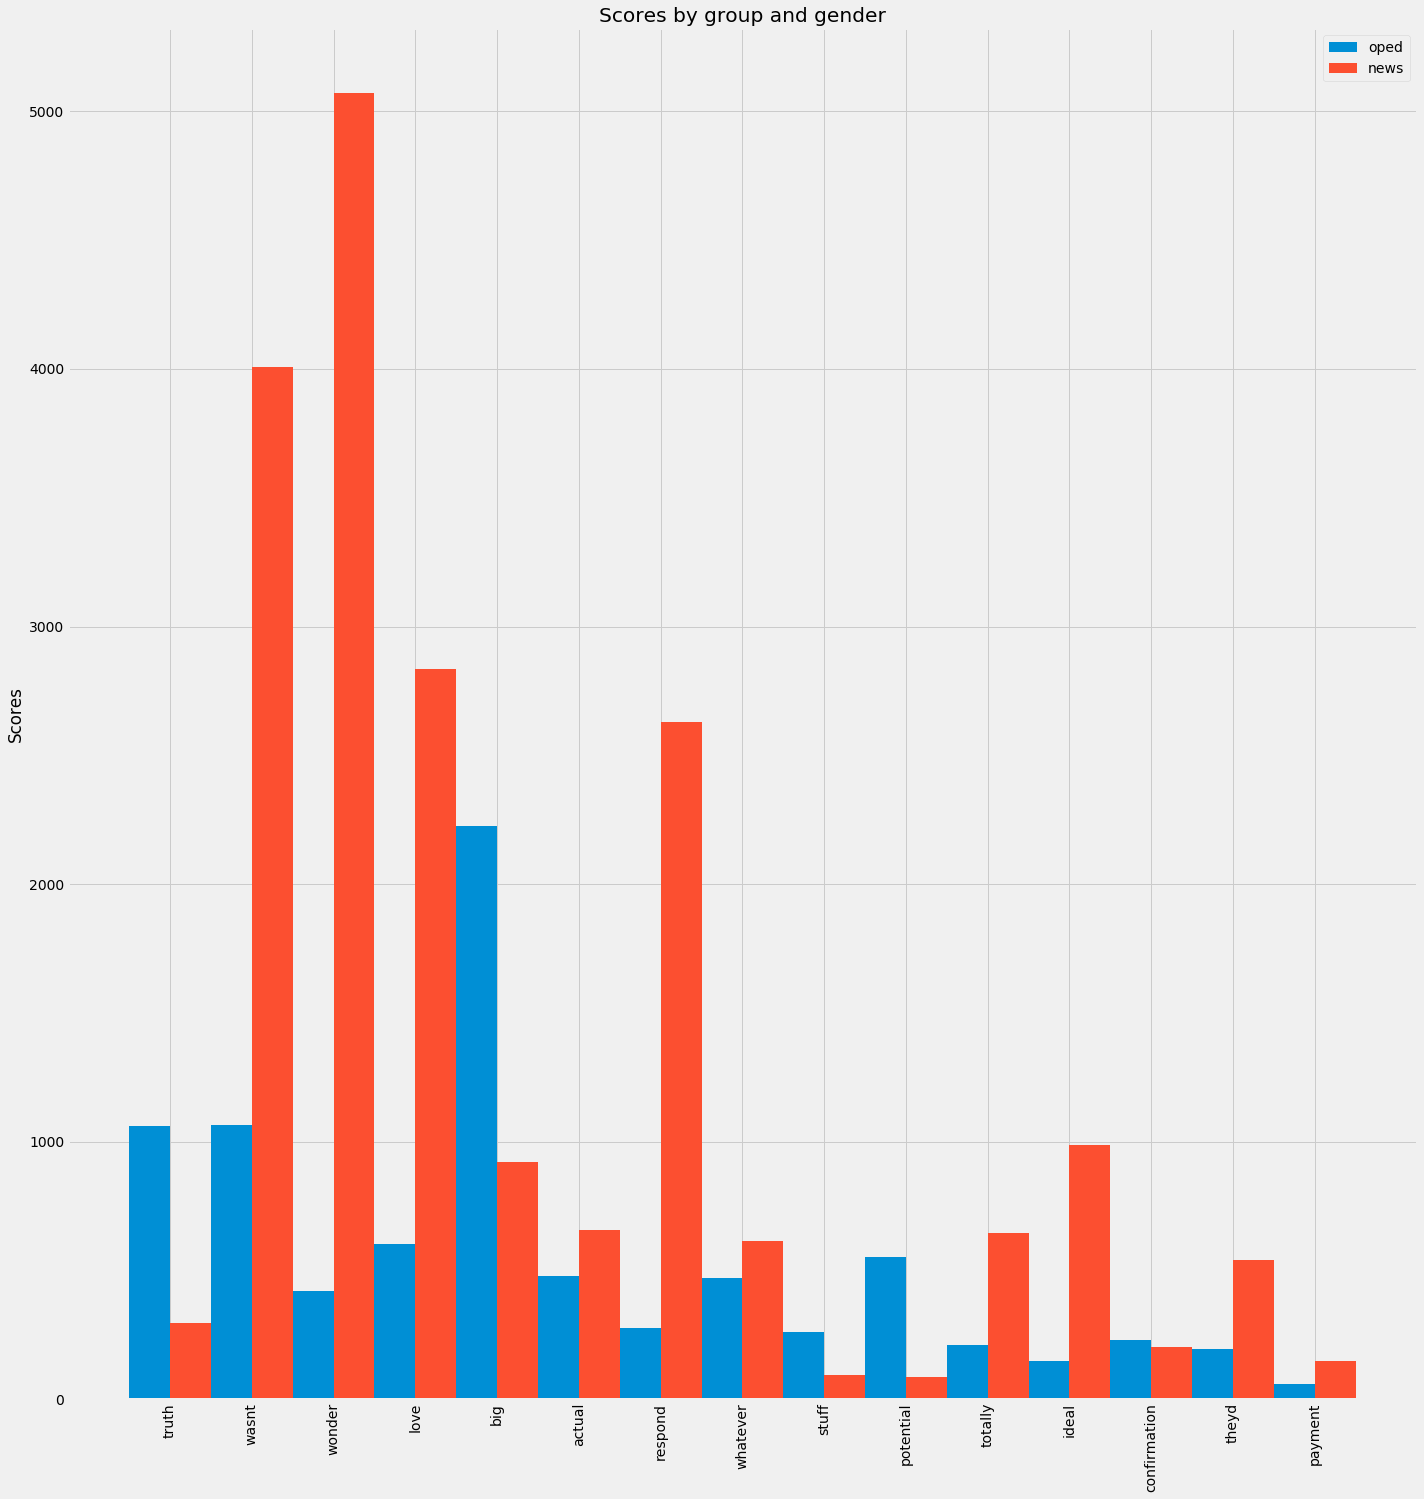

In [295]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = oped_ed_counter.keys()
oped_counts = oped_ed_counter.values()
news_counts = news_counter.values()

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(20,20))
rects1 = ax.bar(x - width/2, oped_counts, width, label='oped')
rects2 = ax.bar(x + width/2, news_counts, width, label='news')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset p/;oints",
#                     ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [272]:
labels

dict_keys(['of', 'the', 'past', 'week', 'in', 'which', 'death', 'led', 'to', 'against', 'and', 'these', 'were', 'met', 'by', 'more', 'including', 'news', 'have', 'made', 'it', 'clear', 'what', 'off', 'far', 'from', 'trying', 'nation', 'is', 'on', 'he', 'seems', 'very', 'close', 'a', 'war', 'think', 'an', 'say', 'that', 'we', 'know', 'did', 'get', 'here', 'story', 'politics', 'over', 'four', 'white', 'racism', 'political', 'power', 'they', 'used', 'already', 'at', 'for', 'people', 'this', 'reality', 'with', 'face', 'point', 'however', 'not', 'see', 'whats', 'going', 'still', 'economic', 'been', 'opposite', 'populist', 'largely', 'effort', 'through', 'huge', 'rich', 'so', 'take', 'health', 'away', 'back', 'good', 'before', 'coronavirus', 'into', 'had', 'major', 'or', 'who', 'large', '2016', 'thanks', 'his', 'really', 'offered', 'working', 'class', 'up', 'most', 'than', 'only', 'thing', 'you', 'would', 'expect', 'are', 'after', 'all', 'both', 'make', 'enough', 'money', 'much', 'will', 'be

In [260]:
for key, val in oped_ed_counter.items():
    print(key, val)
print('---')
for key, val in news_counter.items():
    print(key, val)


of 117408
the 222616
past 1833
week 2234
in 71225
which 9034
death 673
led 818
to 121799
against 3669
and 98315
these 4172
were 9938
met 418
by 19281
more 14321
including 1737
news 1809
have 21962
made 3179
it 26389
clear 1630
what 8163
off 2186
far 2264
from 16798
trying 1557
nation 1265
is 46924
on 29608
he 22521
seems 1646
very 2596
close 759
a 98911
war 1860
think 2940
an 15786
say 3097
that 68516
we 11031
know 3110
did 3886
get 4307
here 1362
story 1507
politics 2985
over 5329
four 1077
white 2142
racism 447
political 6502
power 3206
they 14463
used 1660
already 1918
at 14669
for 38490
people 9594
this 15470
reality 1012
with 25675
face 1124
point 2093
however 1172
not 18820
see 2802
whats 569
going 2631
still 3299
economic 2651
been 9191
opposite 332
populist 412
largely 609
effort 713
through 2739
huge 749
rich 783
so 7611
take 2597
health 3682
away 1683
back 3190
good 2865
before 3024
coronavirus 628
into 6031
had 9400
major 1137
or 13734
who 17563
large 1043
2016 1561
thanks 3

### permutation importance

In [242]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)

In [243]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [244]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<20}")
# #               f"{r.importances_mean[i]:.3f}"
# #               f" +/- {r.importances_std[i]:.3f}")

In [245]:
len(feat_names)

44427

In [ ]:
corpus[0]

In [ ]:
features

# make a plot

In [ ]:
y

In [ ]:
min_df = np.linspace(0,.4,5)

In [ ]:
min_df

In [ ]:
corpus[0]

# min_df_plot

In [ ]:
%%time
num_feat_min = []

min_df = np.linspace(0.01,0.5,5)

for val in min_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
                stop_words=alphabet,
#                 max_df=0.95,
                 min_df=val,
                 max_features=None)
    
    vectorizer_plot.fit(X)
    
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_min.append(len(features))

In [ ]:
learn_vect = TfidfVectorizer(preprocessor=punc_strip,
                 tokenizer=wordnet_tokenize,
#            stop_words=alphabet,
#                max_df=0.95,
             min_df=.2,
             max_features=None)

learn_vect.fit(X)

min_df_features = learn_vect.get_feature_names()
stop_word = learn_vect.get_stop_words()

In [ ]:
len(min_df_features)

In [ ]:
min_df_features

In [ ]:
%%time
fig, ax = plt.subplots()
ax.plot(min_df, num_feat_min);

# 

# max_features

In [ ]:
%%time
TN = []
FP = []
FN = []
TP = []

num_feat = np.linspace(1000,50000,6)

for val in num_feat:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
                stop_words=alphabet,
#                 max_df=0.95,
#                 min_df=val,
                 max_features=int(val))

    #test, train, split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

    X_train = vectorizer_plot.fit_transform(X_train)

    X_test = vectorizer_plot.transform(X_test)
    
    #X, y --> X_resampled, y_resampled
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    recall_rfc = RandomForestClassifier(max_depth=2, random_state=0)

    rf_clf.fit(X_resampled, y_resampled)
    y_pred = rf_clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()
    a, r, p  = metrics_(tn, fp, fn, tp)
    
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    
    
    num_feat_min.append(len(features))

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)
    
# fig, ax = plt.subplots()
# ax.plot(features, scores)

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)